In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime as dt

equities = pd.read_excel("./proshares_analysis_data.xlsx",sheet_name = "hedge_fund_series")
equities.set_index('date', inplace = True)
display(equities)

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
date,,,,,
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027035,-0.006491
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032466,-0.022142
2011-10-31,0.026858,0.043593,0.043320,0.050532,0.025241
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028608,-0.007965
2011-12-31,-0.004479,0.001938,0.001796,0.012875,0.001854
...,...,...,...,...,...
2021-05-31,0.013401,0.000701,0.000666,-0.000784,0.005940
2021-06-30,0.005424,0.005985,0.005991,0.001052,0.002485
2021-07-31,-0.009095,-0.013890,-0.013766,-0.012520,-0.003409


## 1(a)(b)(c) Performance metrics 

In [77]:
def performanceMetrics(returns):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean()  * 12
    metrics['Vol'] = returns.std() * np.sqrt(12)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(12)

    return metrics

metrics = performanceMetrics(equities)
display(metrics)

,Mean,Vol,Sharpe
HFRIFWI Index,0.050784,0.061507,0.825665
MLEIFCTR Index,0.038821,0.053848,0.720933
MLEIFCTX Index,0.037330,0.053682,0.695382
HDG US Equity,0.028100,0.056380,0.498407
QAI US Equity,0.025491,0.045484,0.560434


## 2(a)(b)(c)(d) Tail risk 

In [78]:
def tailRisk(returns):
    tail = pd.DataFrame(index = returns.columns)
    tail['Skewness'] = returns.skew()
    tail['Kurtosis'] = returns.kurtosis()
    tail['VaR(5th)'] = returns.quantile(0.05)
    tail['CVaR(5th)'] = (returns[returns < returns.quantile(0.05)]).mean()
    
    return tail

tail = tailRisk(equities)
display(tail.round(4))

,Skewness,Kurtosis,VaR(5th),CVaR(5th)
HFRIFWI Index,-1.1092,6.7301,-0.0253,-0.0388
MLEIFCTR Index,-0.1867,2.4295,-0.0255,-0.0328
MLEIFCTX Index,-0.1716,2.3756,-0.0256,-0.0327
HDG US Equity,-0.1796,2.5817,-0.0285,-0.0348
QAI US Equity,-0.5451,2.6696,-0.0162,-0.0263


## 2(e) Maximum drawdown

In [79]:
def maximumDrawdown(returns):
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max
    
    max_drawdown = drawdown.min()
    end_date = drawdown.idxmin()
    summary = pd.DataFrame({'Max Drawdown': max_drawdown, 'Min':end_date})
    
    summary['Recover'] = None
    for col in returns.columns:
        idx = returns.index[(returns.index >= end_date[col]).argmax()]
        check_recover = (cum_returns.loc[idx:,col] > rolling_max.loc[idx,col])
        if check_recover.any():                
            summary.loc[col,'Recover'] = check_recover.idxmax()            
    summary['Recover'] = pd.to_datetime(summary['Recover'])
    
    summary.insert(loc=1, column='Peak',value=0)
    for col in returns.columns:
        df = rolling_max.copy()[[col]]
        df.columns=['max']
        df['max date'] = df.index
        df = df.merge(df.groupby('max')[['max date']].first().reset_index(), on='max')
        df.rename(columns={'max date_y': 'max date', 'max date_x': 'date'}, inplace=True)
        df.set_index('date',inplace=True)

        summary.loc[col,'Peak'] = df.loc[end_date[col],'max date']

    summary['Peak'] = pd.to_datetime(summary['Peak'])
    summary['Peak to Recover'] = (summary['Recover'] - summary['Peak'])
        
    return summary


max_drawdown = maximumDrawdown(equities)
display(max_drawdown.round(4))

,Max Drawdown,Peak,Min,Recover,Peak to Recover
HFRIFWI Index,-0.1155,2019-12-31,2020-03-31,2020-08-31,244 days
MLEIFCTR Index,-0.0845,2019-12-31,2020-03-31,2020-11-30,335 days
MLEIFCTX Index,-0.0837,2019-12-31,2020-03-31,2020-11-30,335 days
HDG US Equity,-0.0882,2020-01-31,2020-03-31,2020-11-30,304 days
QAI US Equity,-0.0756,2019-12-31,2020-03-31,2020-07-31,213 days


## 3(a)(b)(c) Regression of hedge funds against SPY

In [80]:
merrill_factors = pd.read_excel("./proshares_analysis_data.xlsx",sheet_name = "merrill_factors")
merrill_factors.set_index('date', inplace = True)

SPY = merrill_factors.iloc[:,:1]
display(SPY)

,SPY US Equity
date,
2011-08-31,-0.054976
2011-09-30,-0.069449
2011-10-31,0.109147
2011-11-30,-0.004064
2011-12-31,0.010440
...,...
2021-05-31,0.006566
2021-06-30,0.022473
2021-07-31,0.024412


In [81]:
def get_ols_metrics(regressors,targets,annualization=1):
    
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors,pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets,pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors,how='inner',lsuffix='y ')
    Y = df_aligned[targets.columns]
    X = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]
        model = LinearRegression().fit(X,y)
        reg.loc[col,'alpha'] = model.intercept_ * annualization
        reg.loc[col,regressors.columns] = model.coef_
        reg.loc[col,'r-squared'] = model.score(X,y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit    
        reg.loc[col,'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg

metrics_mkt = get_ols_metrics(merrill_factors['SPY US Equity'],equities,annualization = 12)
metrics_mkt['Treynor'] = metrics['Mean'] / metrics_mkt['SPY US Equity']
metrics_mkt.round(4)

,alpha,SPY US Equity,r-squared,Info Ratio,Treynor
HFRIFWI Index,-0.0074,0.3943,0.7531,-0.2420,0.1288
MLEIFCTR Index,-0.0142,0.3594,0.8162,-0.6153,0.1080
MLEIFCTX Index,-0.0155,0.3580,0.8150,-0.6713,0.1043
HDG US Equity,-0.0264,0.3692,0.7857,-1.0106,0.0761
QAI US Equity,-0.0166,0.2850,0.7194,-0.6873,0.0894


## 4(a) the differences between SPY and the hedge fund series are

Market beta measures the risk to a hedge fund's return related to SPY - how much a hedge fund moves if SPY moves. In other words, it measures the tendency of a hedge fund's return to change in response to a change in SPY. The Treynor Ratio measures the excess return a hedge fund earns divided by each unit of risk (beta) the investment assumed. The information ratio measures expected return beyond what can be explained by the factor SPY divided by the non-factor volatility, or risk-adjusted alpha. Therefore, beta reveals that the HFRIFWI Index is riskiest regressed against SPY and QAI US Equity is least risky regressed against SPY. The Treynor Ratio reveals that the HFRIFWI Index generates the most excess return over each unit of risk it assumes regressed against SPY and HDG US Equity generates the least excess return over each unit of risk it assumes regressed against SPY. The information ratio for all of the hedge funds is negative, indicating that none of the hedge funds produced excess returns when regressed against SPY.

## 4(b) QAI and HDG comparison

QAI is better than HDG. <br>
From the regression, we see that both funds have relatively high r-squared, which means that the regression fits the data quite well. However, QAI has a bigger alpha than HDG, which means its return is simply higher than HDG on average. <br>
From the Treynor ratio, we also see that the mean return to risk(beta) tradeoff in QAI is higher than HDG. <br>
From the information ratio, we see that the non-factor component of return (alpha + epsilon) to risk for QAI is higher than HDG.
Hence, from their alphas, Information ratio, and Treynor ratio, QAI performs better than HDG.

## 4(c) If HDG and the ML series capture the most notable properties of HFRI

The HDG and the ML series do capture the most notable properties of HFR because they have the same signs for the alpha, information ratio, beta, Treynor ratio, R squared, and tracking error values. This indicates that these series behave similarly when regressed against SPY.

## 5(a) Correlation heatmap

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
HFRIFWI Index,1.000000,0.910392,0.910063,0.897653,0.866714
MLEIFCTR Index,0.910392,1.000000,0.999939,0.984621,0.864431
MLEIFCTX Index,0.910063,0.999939,1.000000,0.984471,0.863734
HDG US Equity,0.897653,0.984621,0.984471,1.000000,0.847597
QAI US Equity,0.866714,0.864431,0.863734,0.847597,1.000000


<AxesSubplot:>

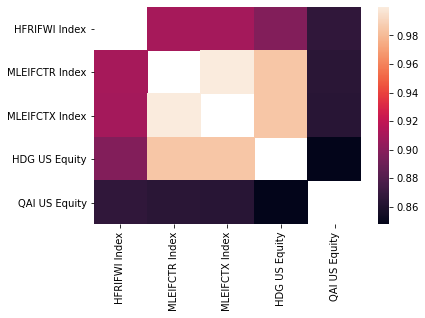

In [82]:
Corr_Matrix = equities.corr()
display(Corr_Matrix)
Corr_Matrix[Corr_Matrix == 1] = None #Nullify values of 1

sns.heatmap(Corr_Matrix)

## 5(b) Highest and lowest correlation

In [92]:
corr_rank = Corr_Matrix .unstack().sort_values().dropna()
pair_max = Corr_Matrix .index[-1]
pair_min = Corr_Matrix .index[0]

print(f'MIN Correlation pair is {pair_min}')
print(f'MAX Correlation pair is {pair_max}')

MIN Correlation pair is HFRIFWI Index
MAX Correlation pair is QAI US Equity


## 6(a) Replicate HFRI with the 6 factors in merrill_factors

In [97]:
result = get_ols_metrics(merrill_factors,equities['HFRIFWI Index'],annualization = 12)
display(result)
#intercept = result[1:]
print("Intercept is: ", result.loc['HFRIFWI Index','alpha'])
print("Betas are as displayed above in the form.")

,alpha,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,r-squared,Info Ratio
HFRIFWI Index,0.01376,0.072022,-0.400591,0.072159,0.106318,0.022431,0.130892,0.855695,0.588931


Intercept is:  0.013760384058106352
Betas are as displayed above in the form.


## 6(b) Are betas realistic

The biggest shorting position is in USGG3M, with 40% of negative weight on this ETF. This is still a realistic position, so in general, the betas are realistic.

## 6(c) R-Squared

In [98]:
print("R-squared is", result.loc['HFRIFWI Index','r-squared'])

R-squared is 0.8556947723602492


## 6(d) Volatility of random error

In [101]:
err_vol = result['alpha']/result['Info Ratio']
display(err_vol)

HFRIFWI Index    0.023365
dtype: float64